<a href="https://colab.research.google.com/github/Danielp8s/DLP2/blob/main/Op2_DL2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Parte 1: Configuración y Carga del Dataset
import os                                         # Módulo para interactuar con el sistema operativo.
import torch                                      # Biblioteca principal de PyTorch.
import torchvision                                # Herramientas y datasets para tareas de visualizacion
import torchvision.transforms as transforms       # Preprocesar imágenes
from torch.utils.data import DataLoader           # Forma de iterar sobre los datasets en mini-batches
from torchvision import datasets                  # Contiene datasets comunes

# Configuración de la ruta del dataset y el batch size
data_dir = '/content/drive/MyDrive/dogs_vs_cats'  # Cambia esta ruta según dataset
batch_size = 16  # Tamaño conjunto de datos

# Definir transformaciones con data augmentation para entrenamiento y preprocesamiento para test
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),      # Redimenciona imagen
    transforms.RandomHorizontalFlip(),      # Voltear imagen horizontalmente
    transforms.ToTensor(),                  # Convierte a tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])    # Normaliza el tensor con medias y desviaciones estándar predefinidas
])

test_transforms = transforms.Compose([
    transforms.Resize(256),                 # Redimensiona imagen
    transforms.CenterCrop(224),             # Recorta el centro de la imagen redimensionada a 224x224 píxeles
    transforms.ToTensor(),                  # Convierte a tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])    # Normaliza el tensor con medias y desviaciones estándar predefinidas
])

# Cargar los datos
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_transforms)     # Carga las imágenes en carpetas y aplica las transformaciones definidas anteriormente a cada imagen cargada
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=test_transforms)        # Carga las imágenes en carpetas y aplica las transformaciones definidas anteriormente a cada imagen cargada

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)     # Permite iterar sobre los datasets en mini-batches (dataloader), as imágenes se mezclarán aleatoriamente en cada época (suffle)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)      # Ya que el orden no es relevante al evaluar

print(f"Número de imágenes de entrenamiento: {len(train_dataset)}")
print(f"Número de imágenes de prueba: {len(test_dataset)}")

Número de imágenes de entrenamiento: 648
Número de imágenes de prueba: 216


In [ ]:
# Parte 2: Selección del Modelo Preentrenado
import torch.nn as nn                     # Aquí se utiliza para definir capas y funciones de pérdida
from torchvision import models            # Proporciona acceso a varios modelos preentrenados

# Selección del modelo preentrenado ResNet18
model = models.resnet18(pretrained=True)           # Carga el modelo ResNet-18 con pesos preentrenados

# Ajustar la última capa para clasificación binaria (2 clases)
model.fc = nn.Linear(model.fc.in_features, 2)           # Reemplaza ultima capa x dos salidas (perro y gato)

# Enviar el modelo a la GPU si está disponible, sino a la CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')       # Esta línea determina si hay una GPU disponible (nvidia)
model = model.to(device)                                                    # Envia el modelo a la GPU o CPU
print(f"Modelo ResNet18 cargado y modificado para clasificación binaria.")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 143MB/s]

Modelo ResNet18 cargado y modificado para clasificación binaria.


In [ ]:
# Parte 3: Configuración del Entrenamiento
import torch.optim as optim                   # optimizadores, actualizar los parámetros del modelo durante el entrenamiento

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()                            # función de pérdida
optimizer = optim.Adam(model.parameters(), lr=0.001)         # Optimizador Adam y LR

print("Criterio de pérdida y optimizador configurados.")

Criterio de pérdida y optimizador configurados.


In [ ]:
# Parte 4: Entrenamiento del Modelo (Simplificado)
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=5):    # parametros de la funcion
    best_accuracy = 0.0                                                                   # inicializacion

    for epoch in range(num_epochs):                                                       # bucle de entrenamiento
        print(f'Epoch {epoch+1}/{num_epochs}')

        # Entrenamiento
        model.train()                                                                     # Modo de entrenamiento
        running_loss = 0.0                                                                # Inicializa para perdida total x mini batch
        for inputs, labels in train_loader:                                               # Recorre los mini batches
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()                                                         # Reinicia los gradientes a cero
            outputs = model(inputs)                                                       # Se realizan las predicciones a partir de los datos de entrada
            loss = criterion(outputs, labels)                                             # Se calcula la pérdida (funcion perdida)
            loss.backward()                                                               # Calcula los gradientes
            optimizer.step()                                                              # Se actualizan los parámetros del modelo utilizando los gradientes calculados.
            running_loss += loss.item()                                                   # Suma la perdida actual al total

        # Evaluación
        model.eval()                                                                      # Modo de evaluación
        correct = 0                                                                       # Inicializador predicciones
        total = 0                                                                         # Inicializador predicciones
        with torch.no_grad():                                                             # No se calcularan los gradientes (memoria y rendimiento)
            for inputs, labels in test_loader:                                            # Recorre los mini batches
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)                                                   # Se realizan las predicciones a partir de los datos de entrada
                _, predicted = torch.max(outputs.data, 1)                                 # Se obtienen las predicciones (clase con mayor prob).
                total += labels.size(0)                                                   # El número total de ejemplos en el conjunto de prueba
                correct += (predicted == labels).sum().item()                             # se incrementa con el número de predicciones correctas.

        accuracy = 100 * correct / total                                                  # Se calcula la precisión en porcentaje
        print(f'Train Loss: {running_loss/len(train_loader):.4f}, Test Accuracy: {accuracy:.2f}%')  # Se imprime la pérdida media del entrenamiento.

        # Guardar el mejor modelo
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            torch.save(model.state_dict(), 'best_resnet18_cats_vs_dogs.pth')

    print(f"Mejor precisión en el conjunto de prueba: {best_accuracy:.2f}%")
    return model

# Ejecutar el entrenamiento
trained_model = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=5)

Epoch 1/5
Train Loss: 0.6270, Test Accuracy: 51.85%
Epoch 2/5
Train Loss: 0.4623, Test Accuracy: 79.63%
Epoch 3/5
Train Loss: 0.4566, Test Accuracy: 82.41%
Epoch 4/5
Train Loss: 0.4476, Test Accuracy: 71.30%
Epoch 5/5
Train Loss: 0.4439, Test Accuracy: 84.72%
Mejor precisión en el conjunto de prueba: 84.72%


In [ ]:
# Parte 5: Evaluar el modelo final
from sklearn.metrics import classification_report, confusion_matrix       # Principales métricas de evaluación
import numpy as np

def evaluate_model(model, test_loader):                                   # El modelo de red neuronal previamente entrenado, El DataLoader que proporciona los datos de prueba
    model.eval()                                                          # Modo de evaluación
    model.to(device)                                                      # Mover el modelo al dispositivo adecuado (GPU o CPU)
    y_true = []                                                           # Almacenar las etiquetas verdaderas
    y_pred = []                                                           # Almacenar las predicciones del modelo

    with torch.no_grad():                                                 # Desactiva el cálculo de gradientes
        for inputs, labels in test_loader:                                # Recorre los mini batches
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)                              # Obtener las predicciones (clase con mayor probabilidad)
            y_true.extend(labels.cpu().numpy())                           # Agrega etiquetas verdaderas
            y_pred.extend(preds.cpu().numpy())                            # Agrega predicciones verdaderas

    # Generar el reporte de clasificación
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=train_dataset.classes))    # Métricas como la precisión, recuperación y puntuación F1 para cada clase.

# Evaluar el modelo
evaluate_model(trained_model, test_loader)

Classification Report:
              precision    recall  f1-score   support

        cats       0.83      0.87      0.85       108
        dogs       0.86      0.82      0.84       108

    accuracy                           0.85       216
   macro avg       0.85      0.85      0.85       216
weighted avg       0.85      0.85      0.85       216



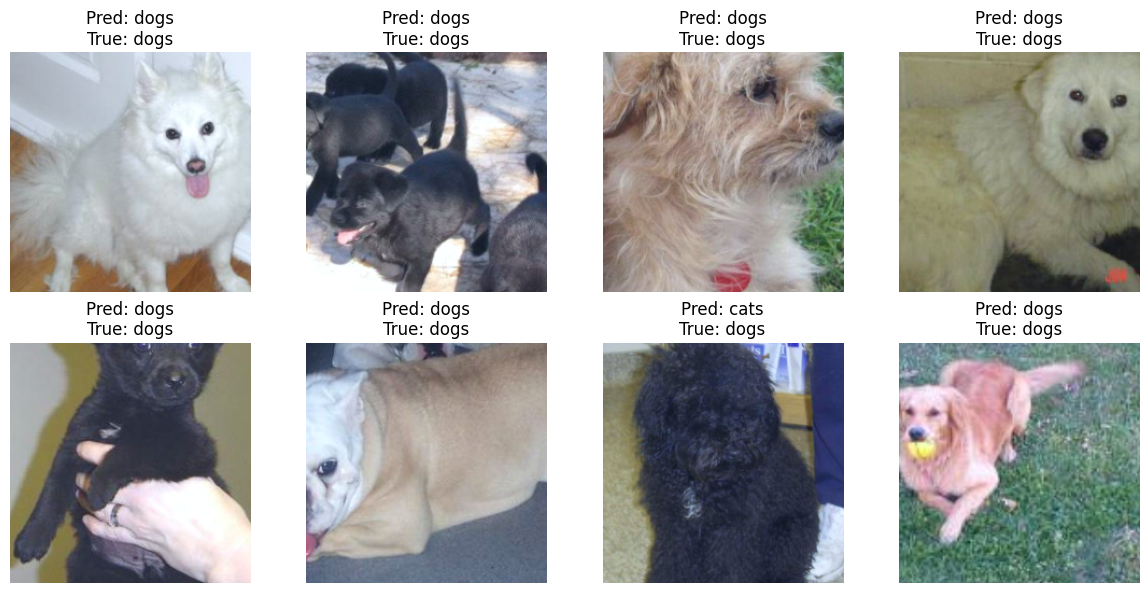

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Visualizar algunas imágenes de la prueba junto con sus predicciones
def visualize_predictions(model, test_loader, device):
    model.eval()
    model.to(device)  # Mover el modelo al dispositivo adecuado (GPU o CPU)

    # Seleccionar un batch aleatorio del test_loader
    inputs, labels = random.choice(list(test_loader))
    inputs, labels = inputs.to(device), labels.to(device)

    # Realizar predicciones
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)

    # Mover las imágenes de vuelta a la CPU para visualizar
    inputs = inputs.cpu()
    labels = labels.cpu()
    preds = preds.cpu()

    # Visualización de las imágenes con predicciones
    plt.figure(figsize=(12, 6))
    for idx in range(8):  # Mostrar 8 imágenes de ejemplo
        ax = plt.subplot(2, 4, idx+1)
        img = inputs[idx].numpy().transpose((1, 2, 0))
        img = np.clip(img * 0.229 + 0.485, 0, 1)  # Desnormalizar para visualizar correctamente
        plt.imshow(img)
        plt.title(f"Pred: {train_dataset.classes[preds[idx]]}\nTrue: {train_dataset.classes[labels[idx]]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualizar algunas predicciones
visualize_predictions(trained_model, test_loader, device)